# Analyse Immobilienkredit 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
import datetime as dt

## input

In [2]:
Kredit0 = 500_000

Zinssatz = 1
Rate     = 2000
Ende_Zinsbindung = dt.datetime(2030,1,1)

## Prognose-Funktion

In [3]:
Heute = dt.datetime.now()
Monate_Zinsbindung = (Ende_Zinsbindung.year - Heute.year)*12 + Ende_Zinsbindung.month - Heute.month - 1


def Prognose( Kredit0 = Kredit0, 
            Zinssatz = Zinssatz, Rate = Rate, Sondertilgung = 10_000, 
            Zinssatz_Anschluss = 5, Monate_Zinsbindung = Monate_Zinsbindung,
            Ausgabe = False ):  
    
    Kredit_vec = [-Kredit0]
    Zinsen_vec = [0]
    while Kredit_vec[-1] <= 0:
        Monate = len(Kredit_vec)
        if Monate < Monate_Zinsbindung:
            Zinsen = Kredit_vec[-1]*Zinssatz/100/12
        else:
            Zinsen = Kredit_vec[-1]*Zinssatz_Anschluss/100/12
        Kredit_vec.append(Kredit_vec[-1] + Rate + Zinsen)   # monatliche Rate
        Zinsen_vec.append(Zinsen)
        if Monate % 12 == 0:    # alle 12 Monate
            Kredit_vec[-1] += Sondertilgung
            
    Monate_vec = [ Heute + n*dt.timedelta(days=365.25/12) for n in range(Monate+1) ]
    Zinsen_vec = np.array(Zinsen_vec)
    Zinsen_Prognose = int(- sum(Zinsen_vec) )
    Restkredit = int(- Kredit_vec[Monate_Zinsbindung] )
    
    if Ausgabe:
        print(f'jährliche Sondertilgung: {int(Sondertilgung)} €')
        print(f'Anschluss-Zinssatz: {Zinssatz_Anschluss} %')
        
        # Plot Tilgung & Zinsen über Jahre
        plt.plot(Monate_vec[1:Monate], Rate+Zinsen_vec[1:Monate], label='Tilgung')
        plt.plot(Monate_vec[1:Monate], -Zinsen_vec[1:Monate],     label='Zinsen' )
        plt.title('Tilgung & Zinsen')
        plt.xlabel('Jahre')
        plt.ylabel('€')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Plot Kreditsumme über Jahre
        plt.plot(Monate_vec[1:Monate], Kredit_vec[1:Monate], drawstyle='steps-post', label='Prognose'     )
        plt.title('Kreditsumme')
        plt.xlabel('Jahre')
        plt.ylabel('€')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Ausgabe Zeit & bezahlte Zinsen
        print(f'--> Tilgung in {int(Monate/12)} Jahren und {Monate%12} Monaten (' + Monate_vec[Monate].strftime('%b %Y') + ')')
        print(f'--> {Zinsen_Prognose} € Zinsen bezahlt')
           
    return Monate , Zinsen_Prognose, Restkredit

## Prognose detailliert

jährliche Sondertilgung: 5000 €
Anschluss-Zinssatz: 5 %


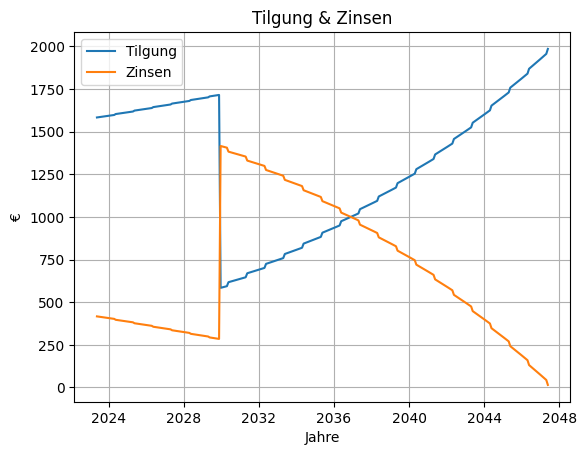

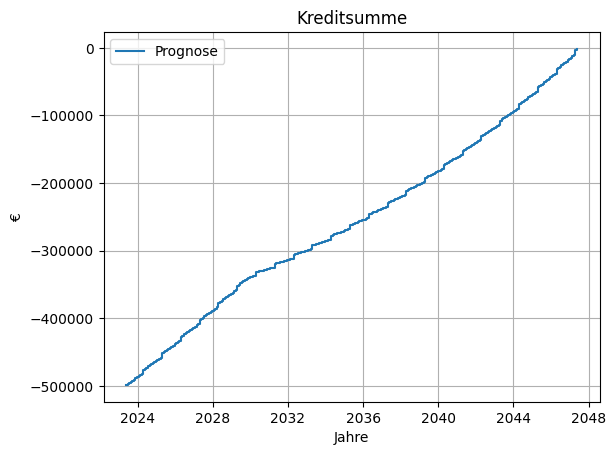

--> Tilgung in 24 Jahren und 2 Monaten (Jun 2047)
--> 199552 € Zinsen bezahlt


In [4]:
_ = Prognose( Sondertilgung = 5000, Zinssatz_Anschluss = 5, Ausgabe=True)

## Prognose alle Szenarien

abhängig von Sondertilgung & Anschluss-Zinssatz

In [5]:
Sondertilgung_vec      = [0, 5000, 10_000, 15_000]
Zinssatz_Anschluss_vec = [1, 3, 5]

In [6]:
Monate = np.empty((len(Sondertilgung_vec),len(Zinssatz_Anschluss_vec)), dtype=int)
Zinsen = np.empty((len(Sondertilgung_vec),len(Zinssatz_Anschluss_vec)), dtype=int)
Kredit = np.empty((len(Sondertilgung_vec),len(Zinssatz_Anschluss_vec)), dtype=int)

for i, Sondertilgung in enumerate(Sondertilgung_vec):
    for j, Zinssatz_Anschluss in enumerate(Zinssatz_Anschluss_vec):
        Monate[i,j] , Zinsen[i,j] , Kredit[i,j] = Prognose(Sondertilgung = Sondertilgung, Zinssatz_Anschluss = Zinssatz_Anschluss )

title = [str(a)+'%' for a in Zinssatz_Anschluss_vec ]
title.insert(0,'Sondertilgung €/a')

Sondertilgung_vec = [int(a) for a in Sondertilgung_vec]

- Rest-Kredit in Anschluss-Finanzierung (k€)

In [7]:
Restkredit = np.column_stack((Sondertilgung_vec , np.intp(Kredit[:,0]/1000) , np.intp(Kredit[:,0]/Kredit0*100) ))
Restkredit = pd.DataFrame(Restkredit, columns = ['Sondertilgung €/a','Kredit','%'])

print(Restkredit.to_string(index=False))

 Sondertilgung €/a  Kredit  %
                 0     369 73
              5000     338 67
             10000     307 61
             15000     276 55


- Zinsen / Monat in Anschluss-Finanzierung

In [8]:
Zinsen_Monat = np.column_stack((Sondertilgung_vec , np.intp(Kredit * Zinssatz_Anschluss_vec/100/12) ))
Zinsen_Monat = pd.DataFrame(Zinsen_Monat, columns = title)

print(Zinsen_Monat.to_string(index=False))

 Sondertilgung €/a  1%  3%   5%
                 0 307 924 1542
              5000 281 846 1413
             10000 255 769 1284
             15000 230 691 1154


- Jahre bis vollständige Tilgung

In [9]:
Jahre = np.column_stack(( Sondertilgung_vec , np.round(Monate/12,1) ))
Jahre = pd.DataFrame(Jahre, columns = title)

print(Jahre.to_string(index=False))

 Sondertilgung €/a   1%   3%   5%
               0.0 23.4 27.4 36.3
            5000.0 19.0 21.0 24.2
           10000.0 16.0 17.1 18.8
           15000.0 14.0 14.7 15.3


- jährliche Rendite von Sondertilgung jetzt

In [10]:
Rendite = Zinssatz * Monate_Zinsbindung/Monate + Zinssatz_Anschluss_vec*(Monate - Monate_Zinsbindung)/Monate

Rendite = np.column_stack((Sondertilgung_vec , np.round(Rendite,1)))
Rendite = pd.DataFrame(Rendite, columns = title)

print(Rendite.to_string(index=False))

 Sondertilgung €/a  1%  3%  5%
               0.0 1.0 2.5 4.3
            5000.0 1.0 2.4 3.9
           10000.0 1.0 2.2 3.6
           15000.0 1.0 2.1 3.3


- Zinsen bezahlt insgesamt (k€)

In [11]:
Zinsen = np.column_stack((Sondertilgung_vec , np.intp(Zinsen/1000) ))
Zinsen = pd.DataFrame(Zinsen, columns = title)

print(Zinsen.to_string(index=False))

 Sondertilgung €/a  1%  3%  5%
                 0  60 156 370
              5000  49 106 199
             10000  41  78 129
             15000  36  60  91
